# Read Nearline data (ROOT) into pandas from ROOT files with NTuples and TH1s

## 1) Form a list of ROOT files in the target dir.

In [ ]:
import os, re

target_dir = "DATA/Nearline/" # TODO impliment as argparse in proper Python code 

#storage 
file_list=[] 
run_list=[]

# loop over files in the directroy 
for file in os.listdir(target_dir):
    file_name=file.replace(".", "_") # make all seperations the same 
    file_name_split=re.split('_', file_name) # split into e.g. "NearlinePlots", "30528", "root"
    if(file_name_split[0] == "NearlinePlots"): # check we got a correct file 
        run_list.append(file_name_split[1]) # form list of all runs 
        file_list.append(file) # ... of all files 

print("Found", len(file_list), "nearline files for runs:", *run_list) # "*" unpacked the list for print function

## 2) Loop over the file structure

In [2]:
# See https://github.com/scikit-hep/uproot for the manual 
import uproot # get this module by "python3 -m pip install uproot"

file = uproot.open(target_dir+"/"+file_list[0]) # load the ROOT file

top_dir = file["Nearline"] # look into top dir
folders_Tuple = top_dir.values() # list of sub-dirs and 1 NTuple 
print("\nIn top dir", *folders_Tuple)
folders = folders_Tuple[0:-1] # folders only have histograms (e.g. AllStations/Digits/hitTime)
print("\nFollowing folders found", folders)
ntuple = folders_Tuple[-1] # this is our single NTuple
trees=ntuple.keys()
print("\nFond trees in the NTuple", trees)

# TODO there are more and better ways to get TDir, and all objects etc. information see https://github.com/scikit-hep/uproot for the manual \
# TODO form a python dictionary of all availble histograms and Trees, use their names as "varialbes" for pandas storage 
# i.e. you shouldn't have to type them by hand 


In top dir <ROOTDirectory b'AllStations' at 0x000110a98550> <ROOTDirectory b'station00' at 0x000110a981d0> <ROOTDirectory b'station12' at 0x000110a98750> <ROOTDirectory b'station18' at 0x000110a98990> <TTree b'Info_ntup' at 0x00011083f510>

Following folders found [<ROOTDirectory b'AllStations' at 0x000110a98550>, <ROOTDirectory b'station00' at 0x000110a981d0>, <ROOTDirectory b'station12' at 0x000110a98750>, <ROOTDirectory b'station18' at 0x000110a98990>]

Fond trees in the NTuple [b'gpsTime_first', b'gpsTime_first_frac', b'gpsTime_last', b'gpsTime_last_frac', b'nEvents', b'nDigits00', b'nDigits12', b'nDigits18', b'nCandidatesTotal00', b'nCandidatesTotal12', b'nCandidatesTotal18', b'nCandidatesPassQuality00', b'nCandidatesPassQuality12', b'nCandidatesPassQuality18', b'nTracksTotal00', b'nTracksTotal12', b'nTracksTotal18', b'nTracksPassQuality00', b'nTracksPassQuality12', b'nTracksPassQuality18', b'nVerticesTotal00', b'nVerticesTotal12', b'nVerticesTotal18', b'nVerticesPassQuality00', 

In [3]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(url="https://raw.githubusercontent.com/scikit-hep/uproot/master/docs/terminology.png", height=400)

## 3) Read one Histogram into pandas

In [4]:
#Simple code to read data (this should be done though forming dictionaries, see above)
import numpy as np

# Open a histogram 
hist=file["Nearline"+"/"+"AllStations"+"/"+"AllTime/Digits/hitTime"] # load histogram (again should be in a clever loop to avoid manually typing all histos names)
print("\nhist is a TH1F object", hist)

# the histogram in the numpy format (bin edges and frequencies)
hist_data_np = hist.numpy() 
print(hist_data_np)
counts, edges = hist_data_np[0], hist_data_np[1] # len(edges) = len(counts) + 1 
print("\nJust loaded", int(np.sum(counts)), "tracks !!! Overflows/Underflows not included!!!!")

# BONUS: the histogram in the pandas format (bin edges and frequencies)
hist_data = hist.pandas()
hist_data # nice printing only works in JupyetLab (use print() in the .py file https://stackoverflow.com/questions/38487945/how-to-print-a-df-in-terminal-without-loosing-format)


hist is a TH1F object <b'TH1F' b'hitTime' 0x000110a46e30>
(array([0., 0., 0., ..., 0., 0., 0.], dtype=float32), array([0.00000000e+00, 1.48936000e-01, 2.97872000e-01, ...,
       5.95446128e+02, 5.95595064e+02, 5.95744000e+02]))

Just loaded 16 tracks !!! Overflows/Underflows not included!!!!


,count,variance
"[-inf, 0.0)",0.0,0.0
"[0.0, 0.148936)",0.0,0.0
"[0.148936, 0.297872)",0.0,0.0
"[0.297872, 0.44680800000000004)",0.0,0.0
"[0.44680800000000004, 0.595744)",0.0,0.0
...,...,...
"[595.1482560000001, 595.297192)",0.0,0.0
"[595.297192, 595.446128)",0.0,0.0
"[595.446128, 595.5950640000001)",0.0,0.0
"[595.5950640000001, 595.744)",0.0,0.0


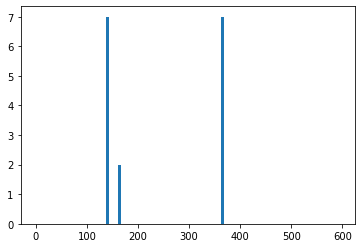

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
binW=edges[1] - edges[0] # fndd bin wdith 
binC=np.linspace(edges[0]+binW/2, edges[-1]-binW/2, len(counts)) # form array of bin centeres
plt.hist(binC, weights=counts, bins=100);# plot our historgram 

## 4) Read NTuple

In [55]:
# Open a Tree
branch=ntuple["gpsTime_first"] # load a brnach (again should be in a clever loop to avoid manually typing all tuple names)
print("\nbranch is a TBranch object", branch)

# look into branch
print("Total enties", branch.numentries)

#load into array
a=branch.array()
print(a)


branch is a TBranch object <TBranch b'gpsTime_first' at 0x000113fa6550>
Total enties 3
[1575757867 1575757884 1575757900]


In [56]:
# BONUS: Alternative way to get ALL data from Tuples/Trees is with (requires ROOT linking to Python!)
import sys,os
sys.path.append(os.environ["JUPYROOT"]) # where JUPYROOT is path to ROOT e.g. /usr/local/Cellar/root/6.18.04/lib/root
# for Python3 install root_numpy with "python3 -m pip install --user root_numpy"
import root_numpy # see http://scikit-hep.org/root_numpy/install.html  
# for Python3 install root_pandas with "python3 -m pip install --user root_pandas"
from root_pandas import read_root # see https://github.com/scikit-hep/root_pandas 

data = read_root(target_dir+file_list[0], 'Nearline/Info_ntup')
data

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



The history saving thread hit an unexpected error (OperationalError('unable to open database file')).History will not be written to the database.Traceback (most recent call last):
  File "/usr/local/Cellar/ipython/7.8.0/libexec/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3326, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-56-12b836fffe38>", line 9, in <module>
    data = read_root(target_dir+file_list[0], 'Nearline/Info_ntup')
  File "/Users/gleb/Library/Python/3.7/lib/python/site-packages/root_pandas/readwrite.py", line 206, in read_root
  File "/Users/gleb/Library/Python/3.7/lib/python/site-packages/root_numpy/_tree.py", line 55, in list_trees
  File "root_numpy/src/tree.pyx", line 60, in _librootnumpy.list_trees
  File "root_numpy/src/tree.pyx", line 51, in _librootnumpy.list_objects
OSError: cannot read DATA/Nearline/NearlinePlots_30528.root

During handling of the above exception, another exception occurred:

Trace

Exception in thread IPythonHistorySavingThread:
Traceback (most recent call last):
  File "/usr/local/Cellar/ipython/7.8.0/libexec/lib/python3.7/site-packages/IPython/core/history.py", line 834, in run
  File "</usr/local/Cellar/ipython/7.8.0/libexec/vendor/lib/python3.7/site-packages/decorator.py:decorator-gen-23>", line 2, in writeout_cache
  File "/usr/local/Cellar/ipython/7.8.0/libexec/lib/python3.7/site-packages/IPython/core/history.py", line 58, in needs_sqlite
  File "/usr/local/Cellar/ipython/7.8.0/libexec/lib/python3.7/site-packages/IPython/core/history.py", line 780, in writeout_cache
  File "/usr/local/Cellar/ipython/7.8.0/libexec/lib/python3.7/site-packages/IPython/core/history.py", line 764, in _writeout_input_cache
sqlite3.OperationalError: unable to open database file

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/gleb/Library/Python/3.7/lib/python/site-packages/ipykernel/iostream.py", line 97, in _

OSError: cannot read DATA/Nearline/NearlinePlots_30528.root